# Business Objective



## Build a forecast model to predict the furniture sales of a certain store

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.statespace.tools import diff

# pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Uploading Data

In [2]:
furniture_df=pd.read_excel("Proj4_TimeSeries_Sales_Data_Project.xls")
furniture_df.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
9493,9494,CA-2016-105207,2016-01-03,2016-01-08,Standard Class,BO-11350,Bill Overfelt,Corporate,United States,Broken Arrow,...,74012,Central,FUR-TA-10000617,Furniture,Tables,Hon Practical Foundations 30 x 60 Training Tab...,1592.850,7,0.0,350.4270
1080,1081,CA-2015-110016,2015-11-29,2015-12-04,Standard Class,BT-11395,Bill Tyler,Corporate,United States,Detroit,...,48227,Central,OFF-PA-10000349,Office Supplies,Paper,Easy-staple paper,19.920,4,0.0,9.3624
2183,2184,CA-2016-128818,2016-05-07,2016-05-11,Standard Class,CJ-12010,Caroline Jumper,Consumer,United States,New York City,...,10009,East,TEC-AC-10001767,Technology,Accessories,SanDisk Ultra 64 GB MicroSDHC Class 10 Memory ...,199.950,5,0.0,21.9945
4799,4800,US-2016-148901,2016-05-14,2016-05-19,Standard Class,MK-17905,Michael Kennedy,Corporate,United States,Jacksonville,...,32216,South,TEC-PH-10003988,Technology,Phones,"LF Elite 3D Dazzle Designer Hard Case Cover, L...",43.600,5,0.2,4.3600
8925,8926,CA-2016-168032,2016-01-30,2016-02-03,Standard Class,DF-13135,David Flashing,Consumer,United States,Rockford,...,61107,Central,OFF-BI-10000546,Office Supplies,Binders,Avery Durable Binders,1.728,3,0.8,-2.6784


## Understanding Data

In [3]:
#Checking the dimension of the time series data
furniture_df.shape

(9994, 21)

In [4]:
# Descriptive statistics are very useful for initial exploration of the variables
# By default, only descriptives for the numerical variables are shown
# To include the categorical ones, you should specify this with an argument
furniture_df.describe(include='all')
# Note that categorical variables don't have some types of numerical descriptives
# and numerical variables don't have some types of categorical descriptives


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994,9994,9994,9994,9994,9994,9994,...,9994.000000,9994,9994,9994,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000
unique,NaN,5009,1237,1334,4,793,793,3,1,531,...,NaN,4,1862,3,17,1850,NaN,NaN,NaN,NaN
top,NaN,CA-2017-100111,2016-09-05 00:00:00,2015-12-16 00:00:00,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,...,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN,NaN,NaN,NaN
freq,NaN,14,38,35,5968,37,37,5191,9994,915,...,NaN,3203,19,6026,1523,48,NaN,NaN,NaN,NaN
first,NaN,NaN,2014-01-03 00:00:00,2014-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2017-12-30 00:00:00,2018-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4997.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55190.379428,NaN,NaN,NaN,NaN,NaN,229.858001,3.789574,0.156203,28.656896
std,2885.163629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32063.693350,NaN,NaN,NaN,NaN,NaN,623.245101,2.225110,0.206452,234.260108
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23223.000000,NaN,NaN,NaN,NaN,NaN,17.280000,2.000000,0.000000,1.728750


In [5]:
#Checking the str/character type variable
furniture_df.describe(include = 'O')

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,4,793,793,3,1,531,49,4,1862,3,17,1850
top,CA-2017-100111,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,5968,37,37,5191,9994,915,2001,3203,19,6026,1523,48


In [6]:
#Checking the numeric and continuous variable
furniture_df.describe(include = 'float64')

,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,229.858001,0.156203,28.656896
std,623.245101,0.206452,234.260108
min,0.444000,0.000000,-6599.978000
25%,17.280000,0.000000,1.728750
50%,54.490000,0.200000,8.666500
75%,209.940000,0.200000,29.364000
max,22638.480000,0.800000,8399.976000


In [7]:
#Checking the numeric and integer variable
furniture_df.describe(include = 'int64')

,Row ID,Postal Code,Quantity
count,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,3.789574
std,2885.163629,32063.693350,2.225110
min,1.000000,1040.000000,1.000000
25%,2499.250000,23223.000000,2.000000
50%,4997.500000,56430.500000,3.000000
75%,7495.750000,90008.000000,5.000000
max,9994.000000,99301.000000,14.000000


In [8]:
#Info command to have a glance on the data types and the missing values
furniture_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [9]:
furniture=furniture_df[(furniture_df.Category=='Furniture')]
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [10]:
furniture.shape

(2121, 21)

In [11]:
data=furniture.sort_values('Order Date').reset_index()
data.head(3)

,index,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7474,7475,CA-2014-167199,2014-01-06,2014-01-10,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,...,42420,South,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2573.820,9,0.0,746.4078
1,7660,7661,CA-2014-105417,2014-01-07,2014-01-12,Standard Class,VS-21820,Vivek Sundaresam,Consumer,United States,...,77340,Central,FUR-FU-10004864,Furniture,Furnishings,"Howard Miller 14-1/2"" Diameter Chrome Round Wa...",76.728,3,0.6,-53.7096
2,866,867,CA-2014-149020,2014-01-10,2014-01-15,Standard Class,AJ-10780,Anthony Jacobs,Corporate,United States,...,22153,South,FUR-FU-10000965,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Ridgewood Wall ...",51.940,1,0.0,21.2954


In [12]:
#Check the time spam
data['Order Date'].min(), data['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

#### checking null values

In [13]:
# data.isnull() # shows a df with the information whether a data point is null 
# Since True = the data point is missing, while False = the data point is not missing, we can sum them
# This will give us the total number of missing values feature-wise
data.isnull().sum()

index            0
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [14]:
#setting oder date as index number
data.set_index("Order Date", inplace = True)


In [44]:
sales=data['Sales']
sales.tail()

Order Date
2017-12-29     258.750
2017-12-29    1207.840
2017-12-29     101.120
2017-12-29     300.980
2017-12-30     323.136
Name: Sales, dtype: float64

In [16]:
energy=sales.resample('M').mean()

<AxesSubplot:xlabel='Order Date'>

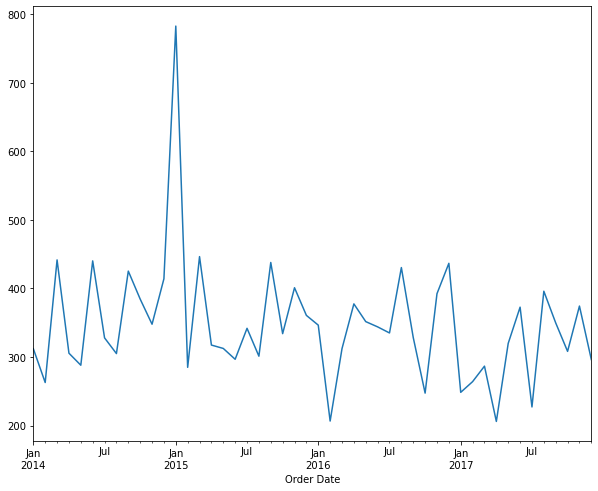

In [17]:
energy.plot(figsize=(10,8))

###### Shows the 4 years sale of furniture

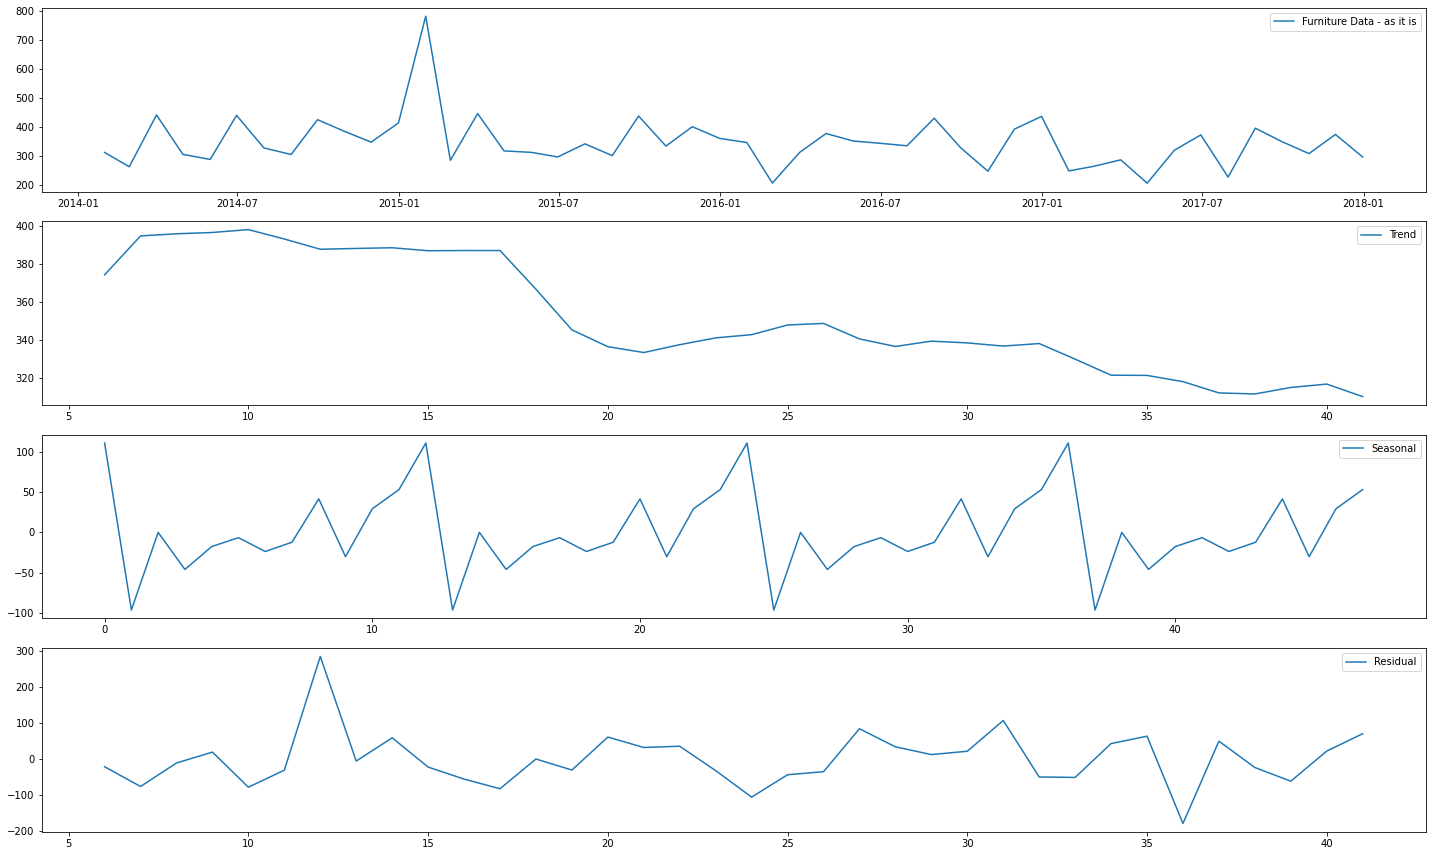

In [18]:
# different components of the Time series data
# period = 12 since the data is monthly

#decomposition=seasonal_decompose(closeprice, period=12)
decomposition=seasonal_decompose(np.asarray(energy), period=12)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid

# plotting all the 4 graphs
fig,ax = plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(energy,label='Furniture Data - as it is')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(d_trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(d_residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()

##### As we can clearly see that in the given data decreasing trend ansd seasonality is there.

## Check for stationarity

In [19]:
# dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    '''
    output:-> 
    1) test statistic, 
    2) p-value, 
    3) number of lags, 
    4) total observations
    
    '''
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [20]:
# check the data for stationarity
ret=checkStationarity(sales); 
ret

'p-value=0.0. Data is stationary'

## Plot ACF and PACF

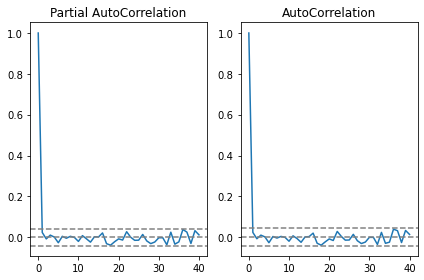

In [21]:
# p -> PACF (partial autocorrelation graph)
# q -> ACF (auto correlation graph)
# d -> differential level (from top)

# since, lags cannot be determined at the beginning, set a random number initially
lag_acf = acf(sales.dropna(), nlags=40)
lag_pacf = pacf(sales.dropna(), nlags=40, method='ols')

# plot PACF (p)
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color="gray")
plt.title("Partial AutoCorrelation")

# plot ACF (q)
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(sales)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(sales)),linestyle='--',color="gray")
plt.title("AutoCorrelation")

plt.tight_layout()

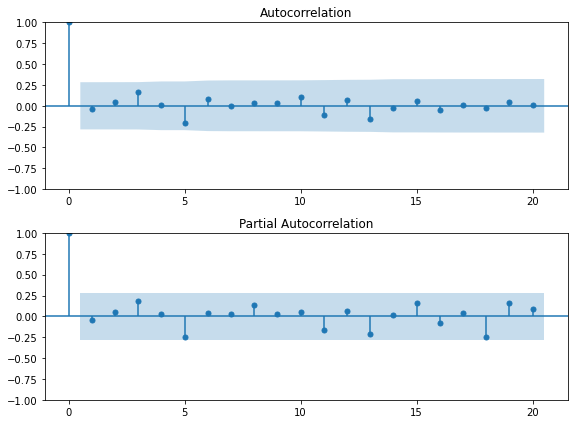

In [22]:
fig = plt.figure(figsize=(8, 6))

# Show ACF
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(energy, lags=20, ax=ax1)

# Show PACF
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(energy, lags=20, ax=ax2)

plt.tight_layout()

In [23]:
energy.shape

(48,)

In [24]:
# split the data into train and test 
# total 48 months are there so I choose accordingly
train = energy.iloc[:40]
test = energy.iloc[40:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 40, test = 8


### Use ARMA for selection of p, d, q

In [25]:
from statsmodels.tsa.arima_model import ARMA
# With p=1
ar_m1 = ARIMA(test, order = (1,0,0))
m1 = ar_m1.fit()
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                    8
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -40.786
Date:                Fri, 25 Nov 2022   AIC                             87.571
Time:                        22:42:14   BIC                             87.810
Sample:                    05-31-2017   HQIC                            85.964
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        332.8954     14.479     22.991      0.000     304.517     361.274
ar.L1         -0.6118      0.473     -1.293      0.196      -1.539       0.316
sigma2      1480.1926    821.510      1.802      0.0

In [26]:
# With p=2
ar_m2 = ARIMA(test, order = (2,0,0))
m2 = ar_m2.fit()
print(m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                    8
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -39.763
Date:                Fri, 25 Nov 2022   AIC                             87.526
Time:                        22:42:14   BIC                             87.843
Sample:                    05-31-2017   HQIC                            85.382
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        331.9719      8.124     40.861      0.000     316.048     347.895
ar.L1         -0.9145      0.757     -1.207      0.227      -2.399       0.570
ar.L2         -0.4646      0.504     -0.922      0.3

In [27]:
# predictions
predictions = m2.predict(0,len(test)-1)
print(predictions)

Order Date
2017-05-31    331.971861
2017-06-30    339.475658
2017-07-31    300.295177
2017-08-31    408.875868
2017-09-30    322.157047
2017-10-31    286.005978
2017-11-30    345.432711
2017-12-31    304.286857
Freq: M, Name: predicted_mean, dtype: float64


In [28]:
# actual vs predicted values
# print("test = {}, predicted = {}".format(len(test), len(predictions) ))
actual = []; pred = []

for i in range(len(predictions)):
    actual.append(test[i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

       actual   predicted        err
0  319.953928  331.971861 -12.017933
1  372.717386  339.475658  33.241728
2  227.173500  300.295177 -73.121677
3  395.945487  408.875868 -12.930381
4  349.737422  322.157047  27.580375
5  308.226313  286.005978  22.220335
6  374.310253  345.432711  28.877541
7  296.296857  304.286857  -7.990001


In [29]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [30]:
# MSE
p=2; q=0;d=0
msg1 = 'ARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse1 = mean_squared_error(df_res1.actual, df_res1.predicted)
print(msg1 + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARIMA Model. Order=(2,0,0)
	MSE = 1114.448813473748
	RMSE = 33.383361326770974


Text(0.5, 1.0, 'ARIMA Model. Order=(2,0,0)')

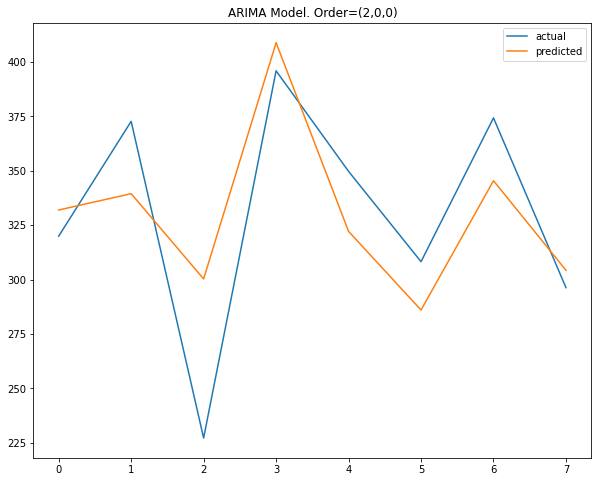

In [31]:
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.title(msg1)

## Use  ARIMA for selection of p, d, q

In [32]:
# start with initial values for p and q
p=1; q=1;d=1
m3 = ARIMA(train,order=(p,1,q)).fit()
print(m3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -234.795
Date:                Fri, 25 Nov 2022   AIC                            475.591
Time:                        22:42:15   BIC                            480.581
Sample:                    01-31-2014   HQIC                           477.381
                         - 04-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0488      0.248     -0.196      0.844      -0.535       0.438
ma.L1         -0.9010      0.197     -4.570      0.000      -1.287      -0.515
sigma2      9484.5824   1152.066      8.233      0.0

In [33]:
 #predictions
start = len(train) 
end = len(train) + len(test) - 1

print('start = {}, end = {}'.format(start,end))

predictions = m3.predict(start,end,typ='levels')
print(predictions)

start = 40, end = 47
2017-05-31    326.521223
2017-06-30    320.647926
2017-07-31    320.934252
2017-08-31    320.920293
2017-09-30    320.920974
2017-10-31    320.920941
2017-11-30    320.920942
2017-12-31    320.920942
Freq: M, Name: predicted_mean, dtype: float64


In [34]:
actual = []; pred = []

for i in range(len(predictions)):
    actual.append(test[i])
    pred.append(predictions[i])

df_res3 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res3['err'] = df_res3.actual - df_res3.predicted
print(df_res3)

       actual   predicted        err
0  319.953928  326.521223  -6.567294
1  372.717386  320.647926  52.069460
2  227.173500  320.934252 -93.760752
3  395.945487  320.920293  75.025194
4  349.737422  320.920974  28.816448
5  308.226313  320.920941 -12.694628
6  374.310253  320.920942  53.389310
7  296.296857  320.920942 -24.624086


In [35]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [36]:
# MSE
msg3 = 'ARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse3 = mean_squared_error(df_res3.actual, df_res3.predicted)
print(msg3 + "\n\tMSE = {}\n\tRMSE = {}".format(mse3,np.sqrt(mse3)))

ARIMA Model. Order=(1,1,1)
	MSE = 2702.8152034230134
	RMSE = 51.988606477025456


Text(0.5, 1.0, 'ARIMA Model. Order=(1,1,1)')

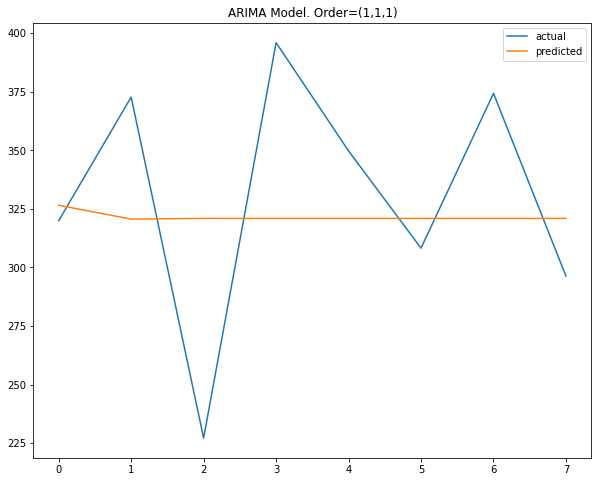

In [37]:
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.title(msg3)

###### Orange line shows the prediction of the test data

## Build the SARIMA model.

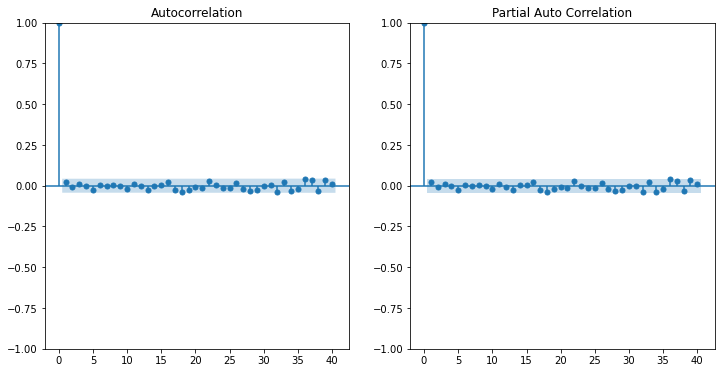

In [38]:
# ACF and PACF plots
ROWS = 1; COLS = 2
fig,ax = plt.subplots(ROWS,COLS,figsize=(12,6))

plot_acf(sales[30:], lags=40, ax=ax[0]);
plt.title("Auto Correlation")

plot_pacf(sales[30:], lags=40, ax=ax[1]);
plt.title("Partial Auto Correlation")

plt.show()

In [39]:
p=1; q=1; d=0
m4 = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   40
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -242.045
Date:                            Fri, 25 Nov 2022   AIC                            494.089
Time:                                    22:42:16   BIC                            502.533
Sample:                                01-31-2014   HQIC                           497.142
                                     - 04-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.117      8.547      0.000       0.770       1.228
ma.L1         -0.9072      0.241   

In [40]:
 #predictions
start = len(train) 
end = len(train) + len(test) - 1

print('start = {}, end = {}'.format(start,end))

predictions = m4.predict(start,end,typ='levels')
print(predictions)

start = 40, end = 47
2017-05-31    317.823718
2017-06-30    321.066612
2017-07-31    319.022940
2017-08-31    319.868028
2017-09-30    323.766573
2017-10-31    317.637373
2017-11-30    322.351658
2017-12-31    324.129086
Freq: M, Name: predicted_mean, dtype: float64


In [41]:
start = len(train)
end = len(train) + len(test) - 1

print('start = {}, end = {}'.format(start,end))

predictions = m4.predict(start=start,end=end,dynamic=True)

df_res4 = pd.DataFrame({'actual':actual, 'predicted':predictions})
df_res4['err'] = df_res4.actual - df_res4.predicted
df_res4.head()

start = 40, end = 47


,actual,predicted,err
2017-05-31,319.953928,317.823718,2.130210
2017-06-30,372.717386,321.066612,51.650775
2017-07-31,227.173500,319.022940,-91.849440
2017-08-31,395.945487,319.868028,76.077460
2017-09-30,349.737422,323.766573,25.970849


In [46]:
# MSE
msg4 = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse4 = mean_squared_error(df_res4.actual, df_res4.predicted)
print(msg4 + "\n\tMSE = {}\n\tRMSE = {}".format(mse4,np.sqrt(mse4)))

SARIMA Model. Order=(1,0,1)
	MSE = 2641.7276870590495
	RMSE = 51.39774009680824


Text(0.5, 1.0, 'ARIMA Model. Order=(1,0,1)')

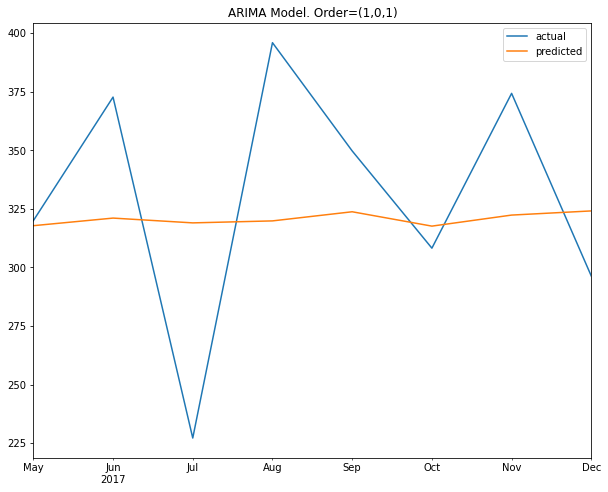

In [43]:
df_res4.actual.plot(figsize=(10,8),legend=True)
df_res4.predicted.plot(legend=True)
plt.title(msg4)

## Conclusion:

###### All the models graph shows the predictions

##### But we have to compare based upon RMSE values of the models


- Model 1. ARMA Model. Order=(2,0,0)
	MSE = 1114.448813473748
	RMSE = 33.383361326770974
- Model 2. ARIMA Model. Order=(1,1,1)
	MSE = 2702.8152034230134
	RMSE = 51.988606477025456
- Model 3. SARIMA Model. Order=(1,0,1)
	MSE = 2641.7276870590495
	RMSE = 51.39774009680824
    
     So, from the above values we can conclude that ARMA model is best and can be used for the future forecating